In [10]:
# First download the Compiler(NVCC) for Nvidia CUDA

!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-ia4fuujq
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-ia4fuujq
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 28f872a2f99a1b201bcd0db14fdbc5a496b9bfd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [11]:
# Load the compiler for Jupyter Notebook
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


## Hardware Specifications:

CPU (Laptop): i5-6500U (2 Cores, 4 Threads)

GPU (Google Colab): Nvidia T4(Tesla Structure), 2560 CUDA Cores (Used 256 at most)


In [12]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>

#define MAX_SIZE 5000
// for now keep it 5000


// Exception Handling, defined here
#define CHECK_CUDA_ERROR(call) { \
    cudaError_t err = call; \
    if (err != cudaSuccess) { \
        printf("CUDA error %s at line %d\n", cudaGetErrorString(err), __LINE__); \
        exit(1); \
    } \
}

// Sigmoid Function, defined here
__device__ double d_sigmoid(double x) {
    return 1.0 / (1.0 + exp(-x));
}

// Kernel for Zero Padding, Defined here
__global__ void zeroPadKernel(double* input, double* paddedOutput, int inputSize, int padWidth, int paddedSize) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x; // to figure out x-axis, dimensions of the block
    if (idx < paddedSize * paddedSize) {
        int x = idx % paddedSize;
        int y = idx / paddedSize;

        if (x < padWidth || y < padWidth ||
            x >= inputSize + padWidth || y >= inputSize + padWidth) {
            paddedOutput[y * paddedSize + x] = 0.0; // keeping it zero, if it goes out of range of padWidth
        } else {
            paddedOutput[y * paddedSize + x] =
                input[(y - padWidth) * inputSize + (x - padWidth)]; // storing the output, in the illusional 2D Matrix
        }
    }
}

// Kernel for convolution operation, defined here as CUDA function by "__...__"
__global__ void convolutionKernel(double* input, double* kernel, double* output, int inputSize, int kernelSize, int outputSize) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < outputSize * outputSize) {
        int x = idx % outputSize; // j
        int y = idx / outputSize; // i

        double sum = 0.0;
        for (int i = 0; i < kernelSize; i++) {
            for (int j = 0; j < kernelSize; j++) {
                sum += input[(y + i) * inputSize + (x + j)] *
                       kernel[i * kernelSize + j];
            }
        }
        output[y * outputSize + x] = sum;
    }
}

// Kernel for sigmoid activation
__global__ void sigmoidKernel(double* input, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size * size) {
        input[idx] = d_sigmoid(input[idx]);
    }
}

// Kernel for max pooling
__global__ void maxPoolingKernel(double* input, double* output, int inputSize, int poolSize, int stride, int outputSize) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < outputSize * outputSize) {
        int outX = idx % outputSize;
        int outY = idx / outputSize;

        double maxVal = -INFINITY;
        int inY = outY * stride;
        int inX = outX * stride;

        for (int i = 0; i < poolSize; i++) {
            for (int j = 0; j < poolSize; j++) {
                double val = input[(inY + i) * inputSize + (inX + j)];
                maxVal = fmax(maxVal, val);
            }
        }
        output[outY * outputSize + outX] = maxVal;
    }
}

// Host functions remain the same
void readMatrixFromFile(const char* filename, double* matrix, int* size) {
    FILE* file = fopen(filename, "r");
    if (!file) {
        perror("Error opening file");
        exit(1);
    }

    fscanf(file, "%d", size);
    for (int i = 0; i < (*size) * (*size); i++) {
        fscanf(file, "%lf", &matrix[i]);
    }
    fclose(file);
}

int main() {
    // Host variables
    int inputSize, kernelSize;
    double *h_input, *h_kernel1, *h_kernel2, *h_kernel3;
    double *h_pooled1, *h_pooled2, *h_pooled3;

    // Allocating memory to Host Matrices, to store input
    h_input = (double*)malloc(MAX_SIZE * MAX_SIZE * sizeof(double));
    h_kernel1 = (double*)malloc(MAX_SIZE * MAX_SIZE * sizeof(double));
    h_kernel2 = (double*)malloc(MAX_SIZE * MAX_SIZE * sizeof(double));
    h_kernel3 = (double*)malloc(MAX_SIZE * MAX_SIZE * sizeof(double));

    // Read input data from files generated from GenerateInput.c
    readMatrixFromFile("input.txt", h_input, &inputSize);
    readMatrixFromFile("kernel1.txt", h_kernel1, &kernelSize);
    readMatrixFromFile("kernel2.txt", h_kernel2, &kernelSize);
    readMatrixFromFile("kernel3.txt", h_kernel3, &kernelSize);

    // Calculating Sizes
    int paddedSize = inputSize + (kernelSize / 2) * 2;
    int convOutputSize = paddedSize - kernelSize + 1;
    int poolSize = 2, stride = 2;
    int outputSize = (paddedSize - poolSize) / stride + 1;

    // Thread configuration
    int threadsPerBlock = 256;
    int paddedElements = paddedSize * paddedSize;
    int convElements = convOutputSize * convOutputSize;
    int poolElements = outputSize * outputSize;

    int paddingBlocks = (paddedElements + threadsPerBlock - 1) / threadsPerBlock;
    int convBlocks = (convElements + threadsPerBlock - 1) / threadsPerBlock;
    int poolBlocks = (poolElements + threadsPerBlock - 1) / threadsPerBlock;

    // Points for Device Memory, to perform CUDA Operations
    double *d_input, *d_paddedInput;
    double *d_kernel1, *d_kernel2, *d_kernel3;
    double *d_conv1, *d_conv2, *d_conv3;
    double *d_pooled1, *d_pooled2, *d_pooled3;

    // Allocating memory to CUDA Matrices, to perform operations in parallel, with exception handling in case if there is error
    // honestly, didn't want to write try catch for like 8 times...
    CHECK_CUDA_ERROR(cudaMalloc(&d_input, inputSize * inputSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_paddedInput, paddedSize * paddedSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_kernel1, kernelSize * kernelSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_kernel2, kernelSize * kernelSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_kernel3, kernelSize * kernelSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_conv1, convOutputSize * convOutputSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_conv2, convOutputSize * convOutputSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_conv3, convOutputSize * convOutputSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_pooled1, outputSize * outputSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_pooled2, outputSize * outputSize * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_pooled3, outputSize * outputSize * sizeof(double)));

    // Allocating memory to host Matrices
    h_pooled1 = (double*)malloc(outputSize * outputSize * sizeof(double));
    h_pooled2 = (double*)malloc(outputSize * outputSize * sizeof(double));
    h_pooled3 = (double*)malloc(outputSize * outputSize * sizeof(double));

    // Copy data to device
    CHECK_CUDA_ERROR(cudaMemcpy(d_input, h_input,
        inputSize * inputSize * sizeof(double), cudaMemcpyHostToDevice));
    CHECK_CUDA_ERROR(cudaMemcpy(d_kernel1, h_kernel1,
        kernelSize * kernelSize * sizeof(double), cudaMemcpyHostToDevice));
    CHECK_CUDA_ERROR(cudaMemcpy(d_kernel2, h_kernel2,
        kernelSize * kernelSize * sizeof(double), cudaMemcpyHostToDevice));
    CHECK_CUDA_ERROR(cudaMemcpy(d_kernel3, h_kernel3,
        kernelSize * kernelSize * sizeof(double), cudaMemcpyHostToDevice));

    // Creating CUDA events for timing
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    // Launch kernels
    zeroPadKernel<<<paddingBlocks, threadsPerBlock>>>(
        d_input, d_paddedInput, inputSize, kernelSize / 2, paddedSize);

    // Convolution operations
    convolutionKernel<<<convBlocks, threadsPerBlock>>>(
        d_paddedInput, d_kernel1, d_conv1, paddedSize, kernelSize, convOutputSize);
    convolutionKernel<<<convBlocks, threadsPerBlock>>>(
        d_paddedInput, d_kernel2, d_conv2, paddedSize, kernelSize, convOutputSize);
    convolutionKernel<<<convBlocks, threadsPerBlock>>>(
        d_paddedInput, d_kernel3, d_conv3, paddedSize, kernelSize, convOutputSize);

    // Sigmoid operations
    sigmoidKernel<<<convBlocks, threadsPerBlock>>>(d_conv1, convOutputSize);
    sigmoidKernel<<<convBlocks, threadsPerBlock>>>(d_conv2, convOutputSize);
    sigmoidKernel<<<convBlocks, threadsPerBlock>>>(d_conv3, convOutputSize);

    // Max pooling operations
    maxPoolingKernel<<<poolBlocks, threadsPerBlock>>>(
        d_conv1, d_pooled1, convOutputSize, poolSize, stride, outputSize);
    maxPoolingKernel<<<poolBlocks, threadsPerBlock>>>(
        d_conv2, d_pooled2, convOutputSize, poolSize, stride, outputSize);
    maxPoolingKernel<<<poolBlocks, threadsPerBlock>>>(
        d_conv3, d_pooled3, convOutputSize, poolSize, stride, outputSize);

    // Copy results back to host
    CHECK_CUDA_ERROR(cudaMemcpy(h_pooled1, d_pooled1,
        outputSize * outputSize * sizeof(double), cudaMemcpyDeviceToHost));
    CHECK_CUDA_ERROR(cudaMemcpy(h_pooled2, d_pooled2,
        outputSize * outputSize * sizeof(double), cudaMemcpyDeviceToHost));
    CHECK_CUDA_ERROR(cudaMemcpy(h_pooled3, d_pooled3,
        outputSize * outputSize * sizeof(double), cudaMemcpyDeviceToHost));

    // Record time
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    // Write results to file, as output
    FILE *file = fopen("output.txt", "w");
    fprintf(file, "Max Pooled Result:\n[");
    for (int k = 0; k < 3; k++) {
        double* current_pooled = (k == 0) ? h_pooled1 :
                                (k == 1) ? h_pooled2 : h_pooled3;

        for (int i = 0; i < outputSize; i++) {
            fprintf(file, "[");
            for (int j = 0; j < outputSize; j++) {
                fprintf(file, "%.8e", current_pooled[i * outputSize + j]);
                if (j < outputSize - 1) fprintf(file, " ");
            }
            fprintf(file, "]");
            if (i < outputSize - 1) fprintf(file, "\n ");
        }
        if (k < 2) fprintf(file, "]\n\n[");
    }
    fprintf(file, "]]\n");
    fclose(file);

    printf("Total execution time: %.2f milliseconds\n", milliseconds);

    // Freeing the CUDA Device Memory
    cudaFree(d_input);
    cudaFree(d_paddedInput);
    cudaFree(d_kernel1);
    cudaFree(d_kernel2);
    cudaFree(d_kernel3);
    cudaFree(d_conv1);
    cudaFree(d_conv2);
    cudaFree(d_conv3);
    cudaFree(d_pooled1);
    cudaFree(d_pooled2);
    cudaFree(d_pooled3);


    // Free Host Memory
    free(h_input);
    free(h_kernel1);
    free(h_kernel2);
    free(h_kernel3);
    free(h_pooled1);
    free(h_pooled2);
    free(h_pooled3);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}

Total execution time: 1.02 milliseconds




###Zero Padding

Zero padding involves adding zeros around the edges of a matrix. For example, if the padding value is 1, two rows and two columns of zeros are added (one on each side). This ensures that operations like convolution or pooling can be applied without issues at the edge cells, maintaining consistent dimensions. Without padding, parts of the pooling or convolution matrix (e.g., a 2x2 matrix) may go out of bounds on the right or bottom sides.

## Convolutional Operation

This refers to the sliding window technique, where a smaller matrix (called a kernel or filter) slides over the input matrix. At each position, an operation (e.g., element-wise multiplication followed by summation) is performed, creating a transformed output matrix. Convolution is used to extract features such as edges or textures from the input.

## Max Pooling

Max pooling involves dividing the input matrix into smaller sections (called pooling regions) and selecting the maximum value within each region. This operation reduces the dimensions of the input while preserving the most significant information, making it useful for downsampling.

In [13]:
# Importing the Libraries, (Numpy for Array, Matplotlib for Plotting Graphs / Comparison)

import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Initializing the arrays with data noted from the programs

kernel_size = [2, 10, 50, 100, 200, 300, 500]

input_size_labels = ['10', '200', '500', '1000', '2500', '5000', '10000']



# Execution times in seconds, from programs

serial = [0.005, 0.195, 8.52, 300 * 60, float('inf'), float('inf'), float('inf')]

cuda_8_thread = [0.0000037, 0.00213, 0.4, 1.178, 24.574, 223, float('inf')]

openmp_thread = [0.07, 0.38, 5.86, 79, 1815.22, 14400, float('inf')]

cuda_256_thread = [0.000004, 0.0096, 0.045, 0.438, 6.3, 59, 627]





In [15]:
# Convert Infinity values (4 hours = 14400 seconds for visualization)

def handle_infinity(times):

    return [t if t != float('inf') else 4 * 3600 for t in times]



In [16]:
# Plotting Individual Graphs

# Graph for Serial Execution
def plot_serial_graph():

    plt.figure(figsize=(10, 6))

    plt.plot(input_size_labels, handle_infinity(serial), marker='o', color='blue', label="Serial", linestyle='--')

    plt.xlabel("Input Size")

    plt.ylabel("Execution Time (seconds)")

    plt.yscale('log')

    plt.title("Serial Execution Time")

    plt.legend()

    plt.grid()

    plt.show()

# Graph for CUDA 4 threads
def plot_cuda_8_graph():

    plt.figure(figsize=(10, 6))

    plt.plot(input_size_labels, handle_infinity(cuda_8_thread), marker='o', color='green', label="CUDA 8 Thread", linestyle='--')

    plt.xlabel("Input Size")

    plt.ylabel("Execution Time (seconds)")

    plt.yscale('log')

    plt.title("CUDA 8 Thread Execution Time")

    plt.legend()

    plt.grid()

    plt.show()

# Graph for OpenMP
def plot_openmp_graph():

    plt.figure(figsize=(10, 6))

    plt.plot(input_size_labels, handle_infinity(openmp_thread), marker='o', color='orange', label="OpenMP 8 Thread", linestyle='--')

    plt.xlabel("Input Size")

    plt.ylabel("Execution Time (seconds)")

    plt.yscale('log')

    plt.title("OpenMP Thread Execution Time")

    plt.legend()

    plt.grid()

    plt.show()


# Graph for CUDA with 256 Threads
def plot_cuda_256_graph():

    plt.figure(figsize=(10, 6))

    plt.plot(input_size_labels, handle_infinity(cuda_256_thread), marker='o', color='red', label="CUDA 256 Thread", linestyle='--')

    plt.xlabel("Input Size")

    plt.ylabel("Execution Time (seconds)")

    plt.yscale('log')

    plt.title("CUDA 256 Thread Execution Time")

    plt.legend()

    plt.grid()

    plt.show()



# Combined graph for comparison

def plot_combined_graph():

    plt.figure(figsize=(12, 8))

    plt.plot(input_size_labels, handle_infinity(serial), marker='o', label="Serial", linestyle='--', color='blue')

    plt.plot(input_size_labels, handle_infinity(cuda_8_thread), marker='o', label="CUDA 8 Thread", linestyle='--', color='green')

    plt.plot(input_size_labels, handle_infinity(openmp_thread), marker='o', label="OpenMP Thread", linestyle='--', color='orange')

    plt.plot(input_size_labels, handle_infinity(cuda_256_thread), marker='o', label="CUDA 256 Thread", linestyle='--', color='red')

    plt.xlabel("Input Size")

    plt.ylabel("Execution Time (seconds)")

    plt.yscale('log')

    plt.title("Comparison of Execution Times")

    plt.legend()

    plt.grid()

    plt.show()





## Plotting The Graphs

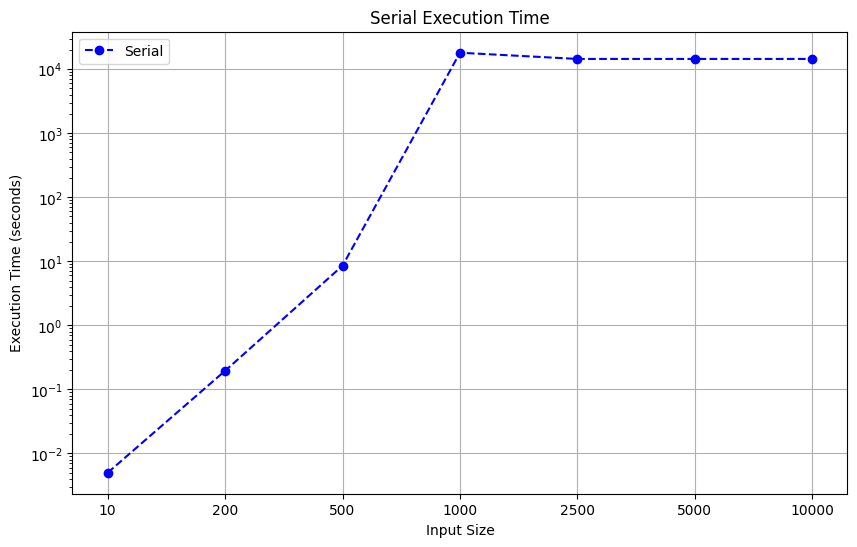

In [17]:
plot_serial_graph()


#### The Serial Program took longer than 2 hours, at Kernel Size = 100, So it is considered too much or in other words, 'Infinity'

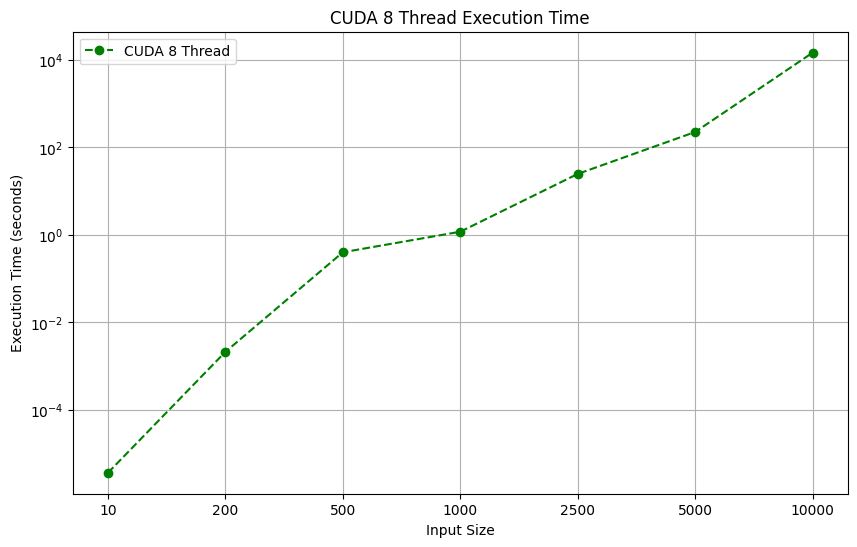

In [18]:
plot_cuda_8_graph()


#### The Cuda Program with 8 threads worked very well, but took longer in kernel size = 500.

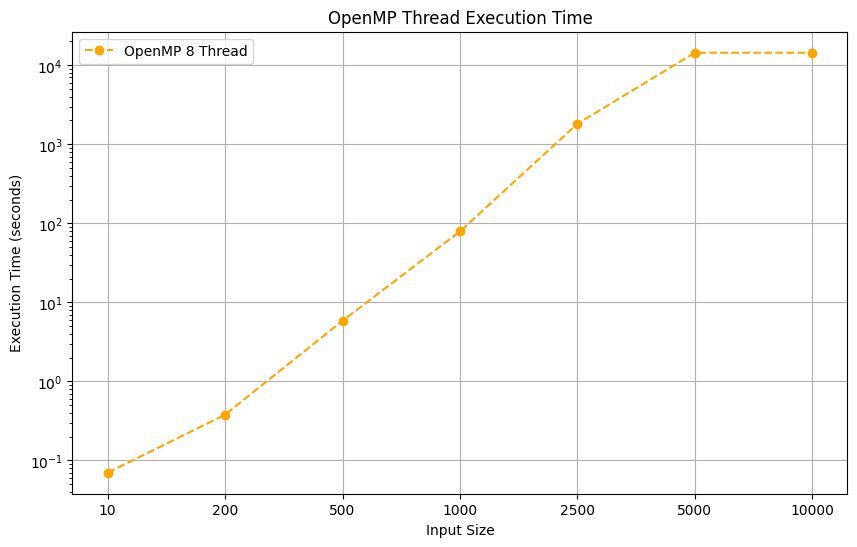

In [19]:
plot_openmp_graph()

#### The OpenMP Program took around 4 hours for Input Size = 2500, Kernel Size = 200, Hence that is why the Point at (300, 10^4) is at the top-most.

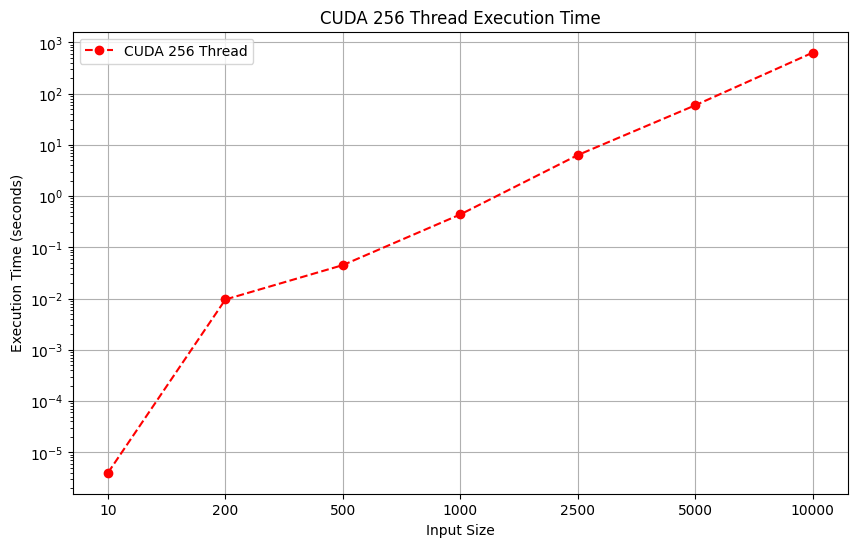

In [20]:
plot_cuda_256_graph()

#### The CUDA Program with 256 threads took 627 seconds with Kernel Size = 500, Input Size = 10000 for the matrices, hence resulting in more efficiency in "The larger the dataset, the more better it performs".

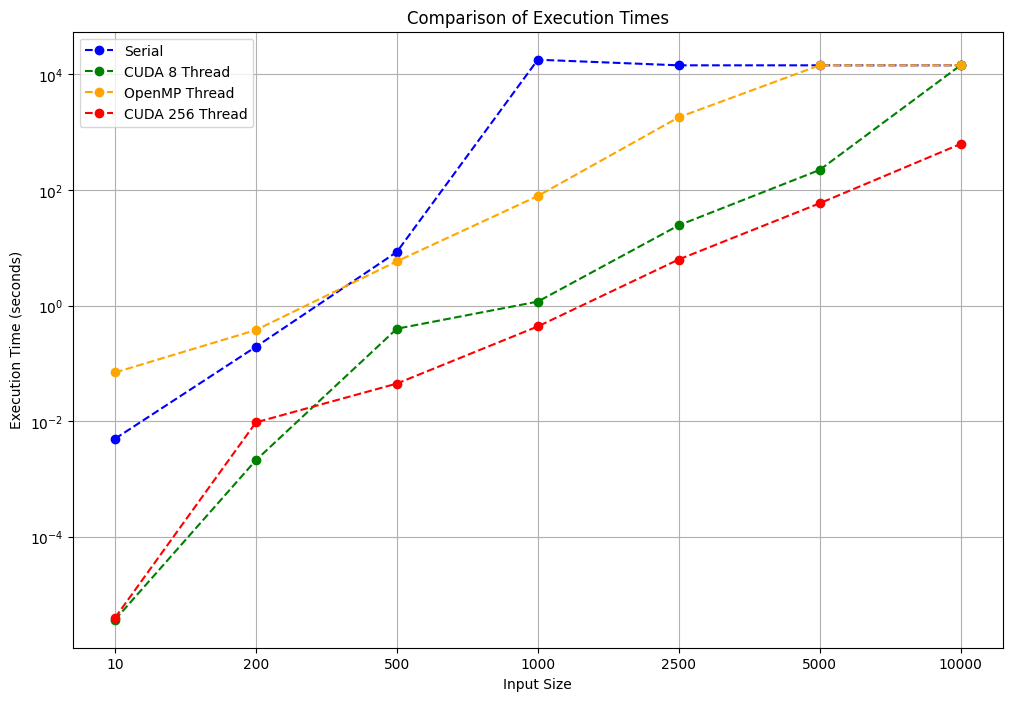

In [21]:
plot_combined_graph()

#### We can see the comparision, the CUDA Program with 256 threads did not manage to cross more than 11 Mins, where as others took very and some might even take days(Serial, OpenMP)